In [ ]:
# Step 1: Installing the software

# MOTOR relies upon femr v1, a package for machine learning on EHR records.

# In particular, MOTOR requires FEMR 0.1.16: https://github.com/som-shahlab/femr/tree/0.1.16

# There are two versions of femr, CPU and GPU
# For this tutorial we will use the CPU version

# https://github.com/som-shahlab/femr

# How to install CPU version
!pip install --upgrade "jax[cpu]==0.4.8"
!pip install "femr[models] == 0.1.16"


# How to install GPU version
#!pip install --upgrade "jax[cuda11_pip]==0.4.8" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install "femr_cuda[models] == 0.1.16"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 MB 10.4 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.8-py3-none-any.whl size=1439671 sha256=35a552ccaf80a62e7056bad283e2a1d3631ac38bbba2d805dc5b3f4193e16184
  Stored in directory: /root/.cache/pip/wheels/09/6f/35/a8fac8b61de8e0d9eb07988481528898561923e260b1fa7d2f
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.16+cuda11.cudnn86
    Uninstalling jaxlib-0.4.16+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.16+cuda11.cudnn86
  Attempting uninstall: jax
    Found existing installation: jax 0.4.16
    Uninstalling jax-0.4.16:
      Successfully uninstalled jax-0.4.16
ERROR: pip's dependency resolver does not currently take into account all the packages

In [1]:
# Step 2: Downloading the artifacts

# The real model is stored on HuggingFace and can be downloaded by cloning https://huggingface.co/StanfordShahLab/motor-t-base
# Real data can be obtained by processing with the FEMR 1.16 library: https://github.com/som-shahlab/femr/tree/0.1.16?tab=readme-ov-file#getting-started

# However, this tutorial is going to be using a synthetic model + synthetic data

# The commands to download the synthetic data
!gdown https://drive.google.com/uc?id=1Yhsz47BG8SZGoIFx0Q_UGEKsfhi2aiDs -O synthetic_data.zip
!unzip -oq synthetic_data.zip

Downloading...
From: https://drive.google.com/uc?id=1Yhsz47BG8SZGoIFx0Q_UGEKsfhi2aiDs
To: /content/synthetic_data.zip
100% 22.6M/22.6M [00:00<00:00, 35.0MB/s]


In [ ]:
# Step 3: Understanding the artifacts

!ls synthetic_data

# clmbr / motor are the models

# extract_lite is the features

# train_person_ids.csv are the patients the model is trained on


clmbr  extract_lite  motor  train_person_ids.csv


In [ ]:
# Step 3b: Understanding extract_lite

import femr.datasets


# The database contains all the features used for the patients
database = femr.datasets.PatientDatabase('synthetic_data/extract_lite')

patients = list(database)


# For example, we can load a single patient with patient_id 110
print(patients[10])

patient = database[patients[10]]

# Print out all the events for the patients
for event in patient.events:
  print(event)

110
Event(start=1992-02-04 00:00:00, code=Birth/Birth, value=None, visit_ids=1, clarity_source=PATIENT)
Event(start=1992-02-04 00:00:00, code=Gender/Gender, value=F, visit_ids=1, clarity_source=PATIENT)
Event(start=1992-02-04 00:00:00, code=Race/Race, value=White, visit_ids=1, clarity_source=PATIENT)
Event(start=1992-04-03 00:00:00, code=ICD10CM/VX5IL6SO, value=None, visit_ids=13, clarity_source=DIAGNOSIS)
Event(start=1992-05-08 00:00:00, code=ICD10CM/NJ9WA5CL, value=None, visit_ids=16, clarity_source=DIAGNOSIS)
Event(start=1992-06-01 00:00:00, code=ICD10CM/9NFBZAEY, value=None, visit_ids=9, clarity_source=DIAGNOSIS)
Event(start=1992-07-26 00:00:00, code=ICD10CM/VGT3XQIL, value=None, visit_ids=4, clarity_source=DIAGNOSIS)
Event(start=1992-08-25 00:00:00, code=ICD10CM/57LXJUED, value=None, visit_ids=13, clarity_source=DIAGNOSIS)
Event(start=1992-11-10 00:00:00, code=ICD10CM/5TPJBYZD, value=None, visit_ids=12, clarity_source=DIAGNOSIS)
Event(start=1992-12-22 00:00:00, code=ICD10CM/TZZCVH

In [ ]:
#@title Generate synthetic prediction times

import random
import csv

random.seed(4533421)

with open('prediction_times.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['patient_id', 'prediction_time'])

  for patient_id in database:
    patient = database[patient_id]
    times = [event.start for event in patient.events][4:]
    chosen_times = list(set(random.choices(times, k=2)))

    for chosen_time in chosen_times:
      writer.writerow([patient_id, chosen_time.isoformat()])

In [ ]:
# Step 4: Choosing prediction times

!head prediction_times.csv

# We expect a csv with a simple format with two columns patient_id, prediciton_time

# For OMOP datasets, patient_id = person_id
# prediction_time indicates what features to use for that patient

!wc -l prediction_times.csv

# Note that a single patient can have multiple prediction times

patient_id,prediction_time
3,2020-08-09T00:00:00
3,2022-06-05T00:00:00
100,1991-03-03T00:00:00
100,1992-05-26T00:00:00
101,1993-11-09T00:00:00
101,1992-11-02T00:00:00
102,1994-02-05T00:00:00
102,1993-03-10T00:00:00
104,1991-08-13T00:00:00
393 prediction_times.csv


In [ ]:
# For example, let's consider patient 3

patient = database[3]

# Print out all the events for the patients
for event in patient.events:
  print(event)

# We have two prediction times for this patient 2020-08-09T00:00:00 and 2022-06-05T00:00:00

# The first will use all data up until the Vitals/HbA1c event

# The second will use all data up till Drug/Atorvastatin

Event(start=1970-01-07 00:00:00, code=Birth/Birth, value=None)
Event(start=1990-01-07 00:00:00, code=Gender/Gender, value=Female)
Event(start=1990-01-07 00:00:00, code=Race/Race, value=White)
Event(start=2020-07-09 00:00:00, code=Vitals/Blood Pressure, value=160.0, units=mmHg)
Event(start=2020-08-09 00:00:00, code=Vitals/HbA1c, value=7.0, dosage=%)
Event(start=2022-05-03 00:00:00, code=ICD10CM/E11.4, value=None)
Event(start=2022-06-05 00:00:00, code=ICD10CM/E10.1, value=None)
Event(start=2022-06-05 00:00:00, code=Note/ProgressNote, value=Patient Bob came to the clinic today)
Event(start=2022-06-05 00:00:00, code=Drug/Atorvastatin, value=None, units=mg, dosage=50)
Event(start=2022-06-06 00:00:00, code=Note/ProgressNote, value=Complicated notes generally need escaping , "
 example)
Event(start=2022-07-06 00:00:00, code=Drug/Multivitamins, value=None, units=ml, dosage=5)


In [ ]:
# Step 5: Computing representations

!ls synthetic_data/motor

# Note that this will be much faster if ran on a GPU

!femr_compute_representations --data_path synthetic_data/extract_lite --model_path synthetic_data/motor --prediction_times_path prediction_times.csv --batch_size 1024 motor_reprs.pkl

dictionary  model
2023-11-06 20:09:33,408 [MainThread  ] [INFO ]  Preparing batches with Namespace(directory='/tmp/tmp9gcecg23/task_batches', data_path='synthetic_data/extract_lite', dictionary_path='synthetic_data/motor/dictionary', task='labeled_patients', transformer_vocab_size=2048, clmbr_survival_dictionary_path=None, labeled_patients_path='prediction_times.csv', is_hierarchical=False, seed=97, val_start=70, test_start=85, batch_size=1024, note_embedding_data=None, limit_to_patients_file=None, limit_before_date=None, num_clmbr_tasks=8192)
2023-11-06 20:09:33,461 [MainThread  ] [INFO ]  Wrote config ...
2023-11-06 20:09:33,461 [MainThread  ] [INFO ]  Starting to load
When mapping codes, dropped 0 out of 2048
When mapping codes, dropped 0 out of 2048
When mapping codes, dropped 0 out of 2048
When mapping codes, dropped 0 out of 2048
When mapping codes, dropped 0 out of 2048
When mapping codes, dropped 0 out of 2048
When mapping codes, dropped 0 out of 2048
When mapping codes, droppe

In [ ]:
# Inspect the format of the result

import pickle

with open('motor_reprs.pkl', 'rb') as f:
    motor_reprs = pickle.load(f)


# We have three keys here, patient_ids, prediction_times, and representations

# Note the representations for this model are of size 257

print(motor_reprs.keys())

print('-' * 80)

for k, v in motor_reprs.items():
    print(k, v.shape)

print('-' * 80)

for k, v in motor_reprs.items():
    if len(v.shape) == 2:
        print(k, v[:10, :])
    else:
        print(k, v[:10])

dict_keys(['representations', 'patient_ids', 'prediction_times'])
--------------------------------------------------------------------------------
representations (392, 257)
patient_ids (392,)
prediction_times (392,)
--------------------------------------------------------------------------------
representations [[ 0.1548  0.1927  1.495  ...  1.805  -0.927   1.    ]
 [ 0.64   -1.572   0.3352 ... -0.4333 -1.084   1.    ]
 [-0.8384  0.31    1.224  ... -0.2367  1.393   1.    ]
 ...
 [-0.8564  1.88    0.6196 ...  0.317   0.2336  1.    ]
 [ 1.054   0.2644 -0.1779 ... -1.586  -1.703   1.    ]
 [ 1.054   0.2644 -0.1779 ... -1.586  -1.703   1.    ]]
patient_ids [  3   3 100 100 101 101 102 102 103 103]
prediction_times [datetime.datetime(2020, 8, 9, 0, 0) datetime.datetime(2022, 6, 5, 0, 0)
 datetime.datetime(1991, 3, 3, 0, 0) datetime.datetime(1992, 5, 26, 0, 0)
 datetime.datetime(1992, 11, 2, 0, 0) datetime.datetime(1993, 11, 9, 0, 0)
 datetime.datetime(1993, 3, 10, 0, 0) datetime.datetime(1

In [ ]:
#@title Generate synthetic labels

import random
import csv
import numpy as np
import scipy

random.seed(4533421)
np.random.seed(3421342)

representation_size = motor_reprs['representations'].shape[1]

weight = np.random.normal(size=(representation_size,))

logits = np.dot(motor_reprs['representations'], weight)

probabilities = scipy.special.expit(logits)

sampled_probabilties = np.random.rand(len(logits))

labels = sampled_probabilties < probabilities

with open('labels.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['patient_id', 'prediction_time', 'value'])

  for patient_id, prediction_time, label in zip(motor_reprs['patient_ids'], motor_reprs['prediction_times'], labels):
    writer.writerow([patient_id, prediction_time, label])

In [ ]:
# Step 6: Computing labels

# We have to align our labels with our representations

import datetime


# We start by assuming labels have already been generated
!wc -l labels.csv

# Simple csv with a colum value for the label

!head labels.csv

# Load the labels into a Python dictionary

label_map = {}

with open('labels.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        label_map[int(row['patient_id']), datetime.datetime.fromisoformat(row['prediction_time'])] = row['value'] == 'True'

# Now we have to align the labels with our representations

labels = []

for patient_id, prediction_time in zip(motor_reprs['patient_ids'], motor_reprs['prediction_times']):
    labels.append(label_map[patient_id, prediction_time])

print(len(labels))

labels = np.array(labels)

393 labels.csv
patient_id,prediction_time,value
3,2020-08-09 00:00:00,True
3,2022-06-05 00:00:00,False
100,1991-03-03 00:00:00,True
100,1992-05-26 00:00:00,False
101,1992-11-02 00:00:00,True
101,1993-11-09 00:00:00,True
102,1993-03-10 00:00:00,True
102,1994-02-05 00:00:00,False
103,1993-08-06 00:00:00,True
392


In [ ]:
# Step 7: Constructing a held-out test set

# The FM has been trained on a set of patients
# It's important to make sure that set is excluded from the held out test set

!head synthetic_data/train_person_ids.csv

train_person_ids = set()

with open('synthetic_data/train_person_ids.csv') as f:
    reader = csv.DictReader(f)

    for row in reader:
        train_person_ids.add(int(row['person_id']))

print("Number of patients trained on", len(train_person_ids))

# Any patient not in the training set is a valid test set patient
valid_test_set = [patient_id for patient_id in motor_reprs['patient_ids'] if patient_id not in train_person_ids]

print("Possible test patients", len(valid_test_set))

# Note that it's always legal to decrease the size of the test set

random.seed(43534)
valid_test_set.sort()
random.shuffle(valid_test_set)

test_patients = valid_test_set[:len(valid_test_set) // 2]

print("Chosen test patients", len(test_patients))

person_id
157
212
154
182
268
288
194
100
270
Number of patients trained on 100
Possible test patients 198
Chosen test patients 99


In [ ]:
# Step 8: Splitting features/labels into train / held out test

test_mask = np.isin(motor_reprs['patient_ids'], test_patients)

train_features = motor_reprs['representations'][~test_mask, :]
train_labels =labels[~test_mask]

test_features = motor_reprs['representations'][test_mask, :]
test_labels = labels[test_mask]

print("Train size", len(train_labels))

print("Test size", len(test_labels))

Train size 240
Test size 152


In [ ]:
# Step 8: Training a logistic regression model

import sklearn.linear_model

model = sklearn.linear_model.LogisticRegressionCV()
model.fit(train_features, train_labels)

LogisticRegressionCV()

Text(0.5, 1.0, 'Reciever Operator Curve')

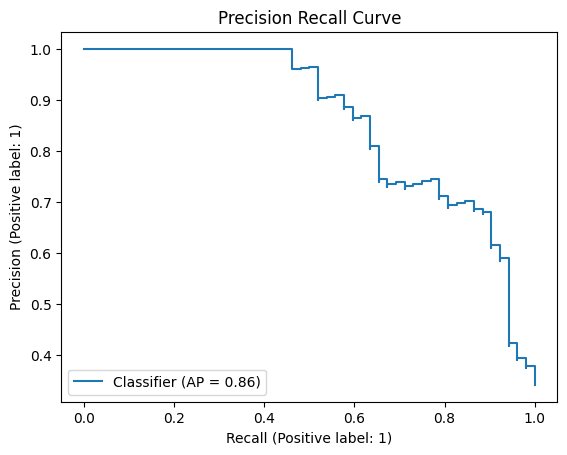

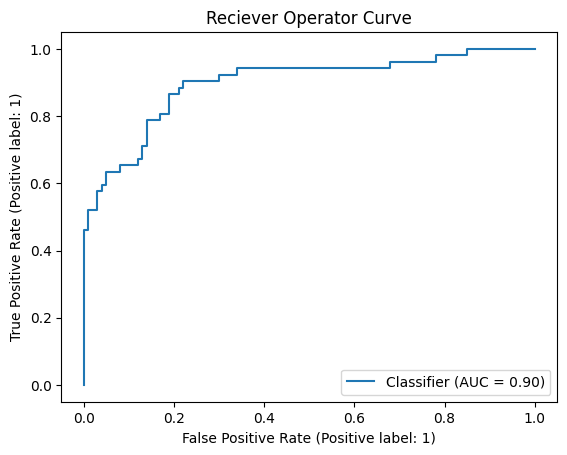

In [ ]:
# Step 9: Performance analysis

import matplotlib.pyplot as plt

probabilities = model.predict_log_proba(test_features)[:, 1]


display =  sklearn.metrics.PrecisionRecallDisplay.from_predictions(
    labels[test_mask], probabilities,
)
plt.title("Precision Recall Curve")


display =  sklearn.metrics.RocCurveDisplay.from_predictions(
    labels[test_mask], probabilities,
)
plt.title("Reciever Operator Curve")